In [219]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
from urllib.request import urlopen, urlretrieve
from shapely.geometry import Polygon, MultiPolygon

import json
import requests,zipfile, io



## administrative boundaries from geoBoundaries

In [234]:
# Download json file from geoBoundaries.

ISO='PHL'       # ISO code for selected country
admLevel=2      #Type 0,1,2,3 for country-,region-, province-, or municipality-level, respectively.

req = requests.get("https://www.geoboundaries.org/gbRequest.html?ISO="+ISO+"&ADM=ADM"+str(admLevel))
dlPath = req.json()[0]['gjDownloadURL']
geoBoundary = requests.get(dlPath).json()

In [235]:
# Convert json file to geodataframe.

adm_list=[]
geom_list=[]
for boundary in geoBoundary["features"]:
    polys=[]
    if boundary["geometry"]['type'] == "MultiPolygon":
        for poly in boundary["geometry"]["coordinates"]:
            polys.append(Polygon(poly[0]))
    else:
        polys.append(Polygon(boundary["geometry"]["coordinates"][0]))
    adm_list.append(boundary["properties"]['shapeName'])
    geom_list.append(MultiPolygon(polys))
adm_gdf=gpd.GeoDataFrame(adm_list,geometry=geom_list,columns=['adm_Name'])
adm_gdf.set_crs(epsg=4326,inplace=True)

,adm_Name,geometry
0,Abra,"MULTIPOLYGON (((120.96795 17.95706, 120.97803 ..."
1,Agusan del Norte,"MULTIPOLYGON (((125.57724 9.45679, 125.59687 9..."
2,Agusan del Sur,"MULTIPOLYGON (((125.91087 8.85625, 125.91461 8..."
3,Aklan,"MULTIPOLYGON (((122.43667 11.59833, 122.43667 ..."
4,Albay,"MULTIPOLYGON (((123.28764 13.04923, 123.28686 ..."
...,...,...
76,Tawi-Tawi,"MULTIPOLYGON (((119.46694 4.58694, 119.46639 4..."
77,Zambales,"MULTIPOLYGON (((120.08285 14.75048, 120.08222 ..."
78,Zamboanga del Norte,"MULTIPOLYGON (((122.09467 7.53152, 122.09467 7..."
79,Zamboanga del Sur,"MULTIPOLYGON (((122.06223 6.87278, 122.06250 6..."


In [236]:
# define target province
which_adm='aklan'
cur_adm=adm_gdf[adm_gdf.adm_Name.str.contains(which_adm,case=False)]
print(cur_adm.adm_Name)

3    Aklan
Name: adm_Name, dtype: object


<AxesSubplot:>

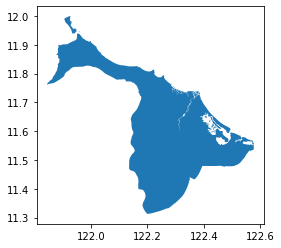

In [237]:
cur_adm.plot()

## OpenStreetMap road data

In [238]:
# Download roads using province as clipping region

convex_hull=True

if convex_hull:
    graph=ox.graph.graph_from_polygon(cur_adm.convex_hull.geometry.values[0], network_type='all_private')
else:
    graph=ox.graph.graph_from_polygon(cur_adm.geometry.values[0], network_type='all_private')
roads=ox.utils_graph.graph_to_gdfs(graph, nodes=False).reset_index()

<AxesSubplot:>

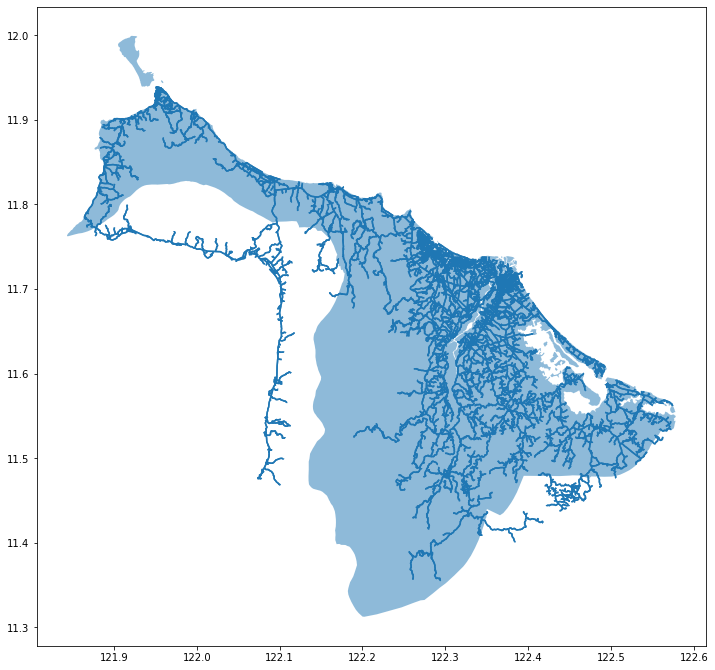

In [239]:
cur_adm.plot(alpha=0.5, figsize=(12,12))
roads.plot(ax=plt.gca())

## NOAH landslide hazard data (vectors)

In [240]:
path='https://open-hazards-ph.s3.amazonaws.com/'

# getting file locations
lhaz_list=urlopen('https://raw.githubusercontent.com/maning/open-hazards-ph/master/noah.txt')
lhaz_fileLoc=[]
for line in lhaz_list:
    if 'LANDSLIDE/vector' in line.decode('utf-8') and which_adm.lower() in line.decode('utf-8').lower():
        lhaz_fileLoc.append(path+line.decode('utf-8').partition('B ')[-1:][0][:-1])

if len(lhaz_fileLoc)==0:
    print("No hazard map available.")
elif len(lhaz_fileLoc)==1:
    lhaz_fileLoc=lhaz_fileLoc
else:
    print("Multiple results. Please refine your search")
    lhaz_fileLoc=[]
    
lhaz_list.close()
print(lhaz_fileLoc[0])

https://open-hazards-ph.s3.amazonaws.com/noah/LANDSLIDE/vector/Aklan_LandslideHazards.shp.geojson.zip


In [241]:
# download and unzip file to memory
print("Accessing file from URL...")
r = requests.get(lhaz_fileLoc[0])
print("...Done.")
z = zipfile.ZipFile(io.BytesIO(r.content))

# load file as json
with z as thezip:
    for zipinfo in thezip.infolist():
        with thezip.open(zipinfo) as thefile:
            geoBoundary=json.load(thefile)
# purge memory
thezip.close()
thefile.close()
z.close()

Accessing file from URL...
...Done.


In [242]:
# Convert json file to geodataframe.
print("\nReading json to geodataframe...")
haz_list=[]
geom_list=[]
for boundary in geoBoundary["features"]:
    polys=[]
    if boundary["geometry"]['type'] == "MultiPolygon":
        for poly in boundary["geometry"]["coordinates"]:
            polys.append(Polygon(poly[0]))
    else:
        polys.append(Polygon(boundary["geometry"]["coordinates"][0]))
    haz_list.append(boundary["properties"]['LH'])
    geom_list.append(MultiPolygon(polys))
lhaz_gdf=gpd.GeoDataFrame(haz_list,geometry=geom_list,columns=['LH'])
lhaz_gdf.set_crs(epsg=4326,inplace=True)
print("...Done")


Reading json to geodataframe...
...Done


<AxesSubplot:>

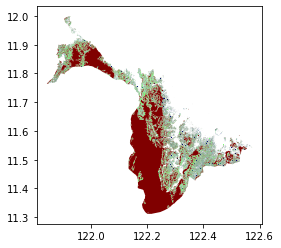

In [243]:
lhaz_gdf.sort_values(['LH']).plot(cmap='jet')

# END CODE

## data sources

### NOAH landslide hazard vector files
- data source: Project NOAH http://noah.up.edu.ph
- data hosted at https://github.com/maning/open-hazards-ph 
- license:  Open Data Commons Open  Database License (ODC-ODbL) https://open-hazards-ph.s3.amazonaws.com/noah/license.pdf, https://opendatacommons.org/licenses/odbl/1-0/
    - You are free:

        - To share: To copy, distribute and use the database.
        - To create: To produce works from the database.
        - To adapt: To modify, transform and build upon the database.

    - As long as you:

        - Attribute: You must attribute any public use of the database, or works produced from the database, in the manner specified in the ODbL. For any use or redistribution of the database, or works produced from it, you must make clear to others the license of the database and keep intact any notices on the original database.
        - Share-Alike: If you publicly use any adapted version of this database, or works produced from an adapted database, you must also offer that adapted database under the ODbL.
        - Keep open: If you redistribute the database, or an adapted version of it, then you may use technological measures that restrict the work (such as DRM) as long as you also redistribute a version without such measures.


### Administrative boundaries 
- data source: NAMRIA and PSA
- data contributed by: OCHA Philippines https://data.humdata.org/organization/27fbd3ff-d0f4-4658-8a69-a07f49a7a853
- data hosted by geoBoundaries, https://www.geoboundaries.org.
- license: Creative Commons Attribution for Intergovernmental Organisations https://data.humdata.org/about/license, https://creativecommons.org/licenses/by/3.0/igo/
    - You are free to:
        - Share — copy and redistribute the material in any medium or format
        - Adapt — remix, transform, and build upon the material for any purpose, even commercially.
        - The licensor cannot revoke these freedoms as long as you follow the license terms.
    - Under the following terms:
        - Attribution — You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.

        - No additional restrictions — You may not apply legal terms or technological measures that legally restrict others from doing anything the license permits."Under the CC BY-IGO license, you are free to share (copy and redistribute the material in any medium or format) and or adapt (remix, transform, and build upon the material) for any purpose, even commercially..." 

### Road data
- data source: OpenStreetMap.org https://www.openstreetmap.org
- OpenStreetMap® is open data, licensed under the Open Data Commons Open Database License (ODbL) by the OpenStreetMap Foundation (OSMF) https://www.openstreetmap.org/copyright, https://opendatacommons.org/licenses/odbl/.
    - You are free to copy, distribute, transmit and adapt our data, as long as you credit OpenStreetMap and its contributors. 
    - If you alter or build upon our data, you may distribute the result only under the same licence. The full legal code explains your rights and responsibilities. 


## references
Runfola D, Anderson A, Baier H, Crittenden M, Dowker E, Fuhrig S, et al. (2020) geoBoundaries: A global database of political administrative boundaries. PLoS ONE 15(4): e0231866. https://doi.org/10.1371/journal.pone.0231866